In [7]:
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np

# Load as RGB
original_img = Image.open("aperson.tif").convert('RGB')

def show_comparison(img_original, img_transformed, title_transformed):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original)
    plt.title("Original (RGB)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_transformed)
    plt.title(title_transformed)
    plt.axis('off')
    plt.show()

print("Setup complete. RGB Image loaded.")

Setup complete. RGB Image loaded.


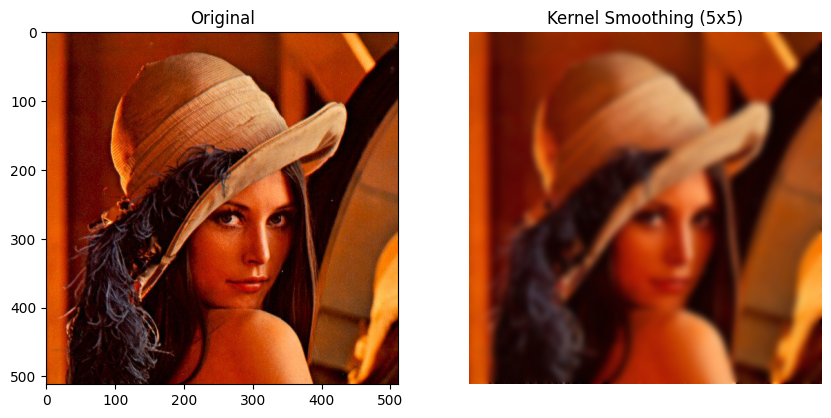

In [11]:
# --- Image Smoothing ---
# --- PARAMETERS TO PLAY WITH ---
# Size of the smoothing box (must be odd numbers usually: 3, 5, 7, etc.)
# Try (3, 3) for subtle smoothing.
# Try (15, 15) for heavy blurring.
box_width, box_height = 5, 5
# -------------------------------

# 1. Create the Weights List
# For a Box filter, every neighbor has equal weight (1).
# We need a flat list of 1s. Length = width * height.
weights = [1] * (box_width * box_height)

# 2. Calculate Scale
# Essential! We sum the weights (25) so we can divide by them.
# If we don't divide, the pixel values will sum up to > 255 and become pure white.
scale = sum(weights) 

# 3. Create the Kernel Object
# Pillow detects this is an RGB image and applies the kernel to R, G, and B automatically.
custom_box_kernel = ImageFilter.Kernel(
    (box_width, box_height), 
    weights, 
    scale=scale
)

# 4. Apply

iterations = 10
smoothed_img = original_img.filter(custom_box_kernel)
for i in range(iterations):
    smoothed_img = smoothed_img.filter(custom_box_kernel)

# 5. Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(original_img); plt.title("Original")
plt.subplot(1, 2, 2); plt.imshow(smoothed_img); plt.title(f"Kernel Smoothing ({box_width}x{box_height})")
plt.axis('off'); plt.show()

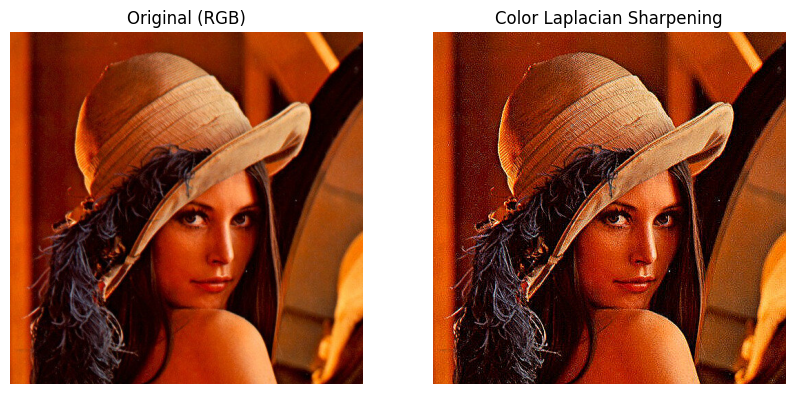

In [9]:
# --- Sharpening ---
# --- PARAMETERS TO PLAY WITH ---
# Try 4 (Edges) or 5 (sharpening).
center_val = 5
# -------------------------------

# 1. Define the Laplacian Kernel (same as our grayscale lab)
laplacian_weights = [
     0, -1,  0,
    -1, center_val, -1,
     0, -1,  0
]
scale = sum(laplacian_weights)
if scale == 0: scale = 1

kernel = ImageFilter.Kernel((3, 3), laplacian_weights, scale=scale)

# 2. Apply to RGB
# Pillow automatically applies this 3x3 grid to the R channel, 
# then the G channel, then the B channel.
sharpened_img = original_img.filter(kernel)

# 3. Visualize
show_comparison(original_img, sharpened_img, "Color Laplacian Sharpening")

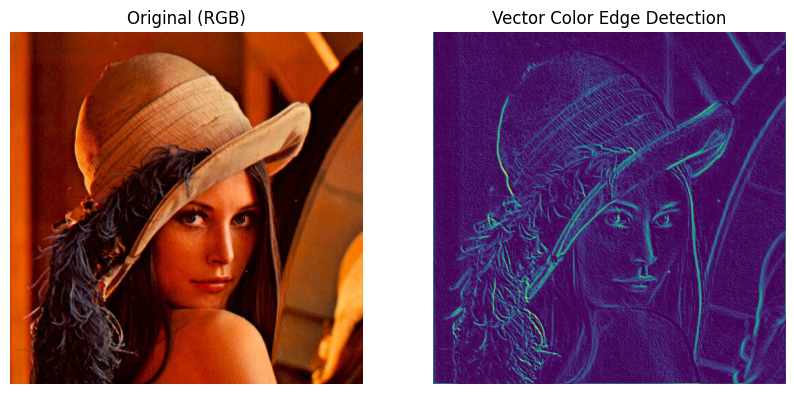

In [10]:
# --- PARAMETERS TO PLAY WITH ---
# No parameters, just pure math!
# -------------------------------

# 1. Convert image to Numpy array (Height x Width x 3)
img_np = np.array(original_img).astype(float)

# 2. Define Sobel Filters
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Helper function to apply convolution to a 2D matrix (one channel)
def apply_sobel(channel):
    # We use a simple sliding window logic or scipy.signal.convolve2d
    # For a strictly 'numpy' and 'intro' approach without extra imports, 
    # we can use the manual approach or a trick: 
    # Pillow's filter is faster. Let's stick to the spirit of the course:
    
    # Extract channel as Pillow Image
    c_img = Image.fromarray(channel.astype('uint8'))
    
    # Calculate Gx and Gy using Pillow Kernels
    gx_img = c_img.filter(ImageFilter.Kernel((3, 3), sobel_x.flatten(), scale=1))
    gy_img = c_img.filter(ImageFilter.Kernel((3, 3), sobel_y.flatten(), scale=1))
    
    gx = np.array(gx_img).astype(float)
    gy = np.array(gy_img).astype(float)
    
    return gx**2 + gy**2  # Return squared magnitude

# 3. Calculate Gradient for R, G, and B separately
# img_np[:, :, 0] is Red, 1 is Green, 2 is Blue
mag_R_sq = apply_sobel(img_np[:, :, 0])
mag_G_sq = apply_sobel(img_np[:, :, 1])
mag_B_sq = apply_sobel(img_np[:, :, 2])

# 4. Combine (Euclidean Distance in Color Space)
# The edge exists if ANY channel changes
total_magnitude = np.sqrt(mag_R_sq + mag_G_sq + mag_B_sq)

# Normalize for display
total_magnitude = (total_magnitude / total_magnitude.max()) * 255
edge_img = Image.fromarray(total_magnitude.astype(np.uint8))

# 5. Visualize
show_comparison(original_img, edge_img, "Vector Color Edge Detection")